**Contents**

1. [Open files](#open_files)


2. [Data preprocessing](#preprocessing)

      2.1 [Variable names](#names)
    
      2.2 [Variable types](#types) 
      
      2.3 [Missing values](#missing_values)
    
      2.4 [Duplicates processing](#duplicates) 
      
      2.5 [Descriptive statistics](#descriptive_stats)
    
      2.6 [Users who are into both groups at once](#two_groups)
      
      2.7 [General structure of datasets](#datasets_structure)


3. [Hypotheses prioritization](#hyp_prior)

      3.1 [ICE](#ice)

      3.2 [RICE](#rice)
      

4. [A/B test analysis](#ab_test)

      4.1 [Cumulative metrics](#cum_metrics)

      4.1.1 [Revenue](#revenue)

      4.1.2 [Average check](#avg_check)

      4.1.3 [Relative change in the cumulative average check in groups](#avg_check_relat)

      4.1.4 [Average number of orders per user](#avg_orders)

      4.1.5 [Relative change in the cumulative average number of orders per visitor in groups](#avg_orders_relat)

      4.2 [Outliers analysis](#outliers)

      4.2.1 [Number of orders per user](#orders)
      
      4.2.2 [Orders cost](#orders_cost)
            
      4.3 [Hypothesis testing](#hyp_test)
      
      4.3.1 [Differences in the average order check between groups ("raw" data)](#raw_avg_check_diff)
      
      4.3.2 [Differences in the number of orders per user between groups ("raw" data)](#raw_order_num_diff)
      
      4.3.3 [Differences in the average order check between groups ("cleaned" data)](#cleaned_avg_check_diff)
      
      4.3.4 [Differences in the number of orders per user between groups ("cleaned" data)](#cleaned_order_num_diff)
  
  
5. [General conclusion](#conclusion)

# Hypothesis prioritization and analysis of A/B test results

**Input data:** data from a large online store containing hypotheses for increasing revenue.


Data files include:
- 9 hypotheses for increasing the revenue of an online store with the specified parameters Reach, Impact, Confidence and Effort,
- Users' orders in the online store,
- Site visits by users.


**Purpose:** Prioritize hypotheses, run an A/B test, and analyze the results.


**Tasks:**
- Apply ICE and RICE frameworks to prioritize hypotheses,
- Look at changes in cumulative revenue, average check and average number of orders per visitor by groups,
- Check for differences in average bookings per visitor between groups,
- Check for differences in the average check between groups,
- Find out if there are significant outliers in the data, "clear" the data from them and repeat the stat. tests,
- Make a decision based on the test results: stop the test and fix the results or continue the A/B test.

In [1]:
# Loading the required libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import datetime as dt
from matplotlib import pyplot as plt
from scipy import stats as st

<a id="open_files"></a> 

## 1. Open files

In [2]:
# Reading files
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [3]:
# Changing display settings so that all hypothesis text is visible
pd.set_option('max_colwidth', 200)

In [4]:
# First 10 rows of datasets
display(hypothesis.head(10))
display(orders.head(10))
visitors.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [5]:
# General information about datasets
print(hypothesis.info())
print()
print(orders.info())
print()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 col

There are a number of data issues:

1) Names of variables - you need to lower case and get rid of CamelCase;

2) The data type of `transactionId` and `visitorId` must be changed from int to str as it is a categorical variable;

3) Data type `date` - must be cast to datetime.

<a id="preprocessing"></a>

## 2. Data preprocessing

<a id="names"></a>

### 2. 1 Variable names

In [6]:
# Changing case for variable names
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower()
visitors.columns = visitors.columns.str.lower()

# Replacing CamelCase Variable Names with Underscores
orders.rename(columns={'transactionid': 'transaction_id',
                       'visitorid': 'visitor_id'}, inplace = True)


# Variable names
print(hypothesis.columns)
print()
print(orders.columns)
visitors.columns 

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')


Index(['date', 'group', 'visitors'], dtype='object')

<a id="types"></a>


### 2.2 Variable types

In [7]:
# Changing Data Types
orders['transaction_id'] = orders['transaction_id'].astype(str)
orders['visitor_id'] = orders['visitor_id'].astype(str)

orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

After all the transformations - let's check their correctness.

In [8]:
# General information about datasets
print(hypothesis.info())
print()
print(orders.info())
print()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   object        
 1   visitor_id      1197 non-null   object        
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 46.9+ KB
None

<class 'panda

In [9]:
# First 10 rows of datasets
display(hypothesis.head(10))
display(orders.head(10))
visitors.head(10)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


The changes were made successfully.

<a id="missing_values"></a>

### 2.3 Missing values

In [10]:
print(hypothesis.isna().sum())
print()
print(orders.isna().sum())
visitors.isna().sum()

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64


date        0
group       0
visitors    0
dtype: int64

There are no missing values.

<a id="duplicates"></a>
 
### 2.4 Duplicates processing

In [11]:
print(hypothesis.duplicated().sum())
print()
print(orders.duplicated().sum())
visitors.duplicated().sum()

0

0


0

There are no obvious duplicates in the data.

<a id="descriptive_stats"></a>

### 2.5 Descriptive statistics

Let's check the descriptive statistics of quantitative and datetime variables for anomalies. And also look at the number of values inside group A and B.

In [12]:
# Descriptive statistics for scale variables
print(orders['revenue'].describe())
print()
visitors['visitors'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64



count     62.000000
mean     607.290323
std      114.400560
min      361.000000
25%      534.000000
50%      624.500000
75%      710.500000
max      770.000000
Name: visitors, dtype: float64

The statistics for the `visitors` table are generally plausible - on 50% of the dates, the number of visitors to the store's website ranged from 534 to 710 people, which can be called a normal fluctuation in traffic.

However, the data of the `orders` table is most likely interfered with by abnormal values of the online store's revenue, which can be judged by the large difference between the median and average revenue (almost 3 times), as well as the maximum revenue value of more than 1 million (at " ordinary "revenue 1-8 thousand).

In [13]:
# Min and Max dates
print(orders['date'].min())
print(orders['date'].max())
print()
print(visitors['date'].min())
print(visitors['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00

2019-08-01 00:00:00
2019-08-31 00:00:00


Both the `orders` and `visitors` tables store data for the entire month of August 2019.

In [14]:
# Counting values for each of the groups
print(orders[orders['group'] == 'A']['visitor_id'].nunique())
print(orders[orders['group'] == 'B']['visitor_id'].nunique())
print()
print(orders[orders['group'] == 'A']['transaction_id'].nunique())
print(orders[orders['group'] == 'B']['transaction_id'].nunique())
print()
print(visitors[visitors['group'] == 'A']['visitors'].sum())
print(visitors[visitors['group'] == 'B']['visitors'].sum())

503
586

557
640

18736
18916


The number of visitors for the A/B test groups is approximately equal to each other - almost 19 thousand in each group, which is approximately equal to the ratio of 49.8 to 50.2 - that is, optimal for the A/B test.

The number of unique users and orders is also approximately the same for groups, with a preponderance towards group B.

<a id="two_groups"></a>

### 2.6 Users who are into both groups at once

Let's see if there are users who accidentally fell into both groups of the A/B test at once.

In [15]:
orders[np.logical_and(orders['group'] == 'A',
                      orders['group'] == 'B')]['visitor_id'].nunique()

0

Fortunately, there were no such users.

<a id="datasets_structure"></a>

### 2.7 General structure of datasets

1) **hypothesis** table:

- `hypothesis` - a brief description of the hypothesis;

- `reach` - coverage of users on a 10-point scale;

- `impact` - impact on users on a 10-point scale;

- `confidence` - confidence in the hypothesis on a 10-point scale;

- `efforts` - the cost of resources to test the hypothesis on a 10-point scale.


2) **orders** table:

- `transaction_id` — order identifier;

- `visitor_id` - identifier of the user who made the order;

- `date` — date when the order was made;

- `revenue` — order revenue;

- `group` — the A/B test group that the order belongs to.


3) Table **visitors**:

- `date` — date;

- `group` — A/B test group;

- `visitors` is the number of users on the specified date in the specified A/B test group.

<a id="hyp_prior"></a>

## 3. Hypotheses prioritization

Let's use the ICE and RICE frameworks to prioritize hypotheses.

<a id="ice"></a>

### 3.1 ICE

```
ICE score = (Impact x Confidence) / Efforts
```

In [16]:
# Change display settings so that all hypotheses text is visible
pd.set_option('max_colwidth', 200)

# Hypothesis priority calculation - ICE methodology
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

# Relative position of hypotheses - highest priority first
display(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


**Findings:**

Highest Priority Hypotheses

- №8 `Запустить акцию, дающую скидку на товар в день рождения` (due to high impact = 9 and confidence = 9)
- №0 `Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей` (due to high impact = 10)
- №7 `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`
- №6 `Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию`
- №2 `Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа`

The remaining hypotheses scored low on impact and confidence, and/or scored high on efforts. That is, with a small impact and certainty of this impact on the user, a disproportionate amount of resources will be expended. Therefore, testing the last four hypotheses will not be rational.

<a id="rice"></a>

### 3. 2 RICE

```
RICE score = (Reach x Impact x Confidence) / Efforts
```

In [17]:
# Change dataset display settings so that all hypotheses text is visible
pd.set_option('max_colwidth', 200)

# Hypothesis priority calculation - RICE methodology
hypothesis['rice'] = hypothesis['reach'] * hypothesis['ice'] 

# Relative positions of hypotheses - highest priority first
display(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Findings:**

Highest Priority Hypotheses

- №7 `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок` (was in third place for the ICE paradigm, high reach = 10) - this hypothesis should be tested first, as it covers all users and can potentially increase the profitability of the store and / or reduce lost profits.
- №2 `Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа` (second place from fifth due to high reach = 8)
- №0 `Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей`
- №6 `Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию`

The remaining hypotheses scored significantly lower in RICE, having 1-4 points in the reach indicator, which corresponds to a small coverage, so we can assume that the development of these hypotheses will not be appropriate.


The difference in the ranking of the hypotheses priority according to the ICE and RICE methodology lies in the inclusion of the change coverage parameter in the latter. It is important to consider both the strength of the hypotheses and the assumption of how many users will be affected by the innovation.

<a id="ab_test"></a>

## 4. A/B test analysis

<a id="cum_metrics"></a>

### 4.1 Cumulative metrics

To visually analyze the results of the A/B test, let's prepare the data:

- get data on visits, number of orders and revenue for each of the dates of the A/B test;
- get cumulative data on orders, visitors and revenue by each date;
- combine the cumulative data into a single table for further work only with it.

Let's start with the visits table `visitors`.

In [18]:
# Create a table with the date and number of visits for group A
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]

# Adding meaningful column names
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

In [19]:
# Count the number of users up to the selected date inclusive in group A
visitors_a_cummulative = (
    visitors_a_daily
    # filter data
    .apply(
        lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max',                  # save date
         'visitors_per_date_a': 'sum'}), # sum up the number of users by this date
           axis=1)
)

# Adding meaningful column names
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

In [20]:
# Create a table with the date and number of visits for group B
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]

# Adding meaningful column names
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

In [21]:
# Count the number of users up to the selected date inclusive in group B
visitors_b_cummulative = (
    visitors_b_daily
    .apply(
        lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max',                  # save date
         'visitors_per_date_b': 'sum'}), # sum up the number of users by this date
           axis=1)
)

# Adding meaningful column names
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

Let's do the same for the orders table `orders`: calculate the cumulative metrics.

In [22]:
# Create a table with the date, number of orders and revenue for group A
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 
          'revenue': 'sum'})
)

# Adding meaningful column names
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

In [23]:
# Count total number of orders and revenue up to selected date inclusive in the group A
orders_a_cummulative = (
    orders_a_daily
    # filter data
    .apply(lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max',                 # store the date
         'orders_per_date_a': 'sum',    # sum up the number of orders to this date
         'revenue_per_date_a': 'sum'}), # sum the revenue up to this date
           axis=1)
    .sort_values(by=['date'])           # sort by date - from earliest to latest
)

# Adding meaningful column names
orders_a_cummulative.columns = ['date', 'orders_cummulative_a', 'revenue_cummulative_a']

In [24]:
# Create a table with the date, number of orders and revenue for group B
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 
          'revenue': 'sum'})
)

# Adding meaningful column names
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

In [25]:
# Count total number of orders and revenue up to selected date inclusive in the group B
orders_b_cummulative = (
    orders_b_daily
    # filter data
    .apply(lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max',                 # store the date
         'orders_per_date_b': 'sum',    # sum up the number of orders to this dateате
         'revenue_per_date_b': 'sum'}), # sum the revenue up to this date
           axis=1)
    .sort_values(by=['date'])           # sort by date - from earliest to latest
)

# Adding meaningful column names
orders_b_cummulative.columns = ['date', 'orders_cummulative_b', 'revenue_cummulative_b']

Now we can combine the tables - the data on the number of visits and revenue, and the cumulative number of orders and visits for the two groups. Based on the resulting `merged_data` table, we will build indicative graphs of changes in cumulative revenue, average check and average number of orders per visitor for each group.

In [26]:
# Merging tables by date column
merged_data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

In [27]:
# First 5 rows 
merged_data.head(5)

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


<a id="revenue"></a>

#### 4.1.1 Revenue

After the necessary transformations, we will plot cumulative revenue graphs by days and groups of A/B testing.

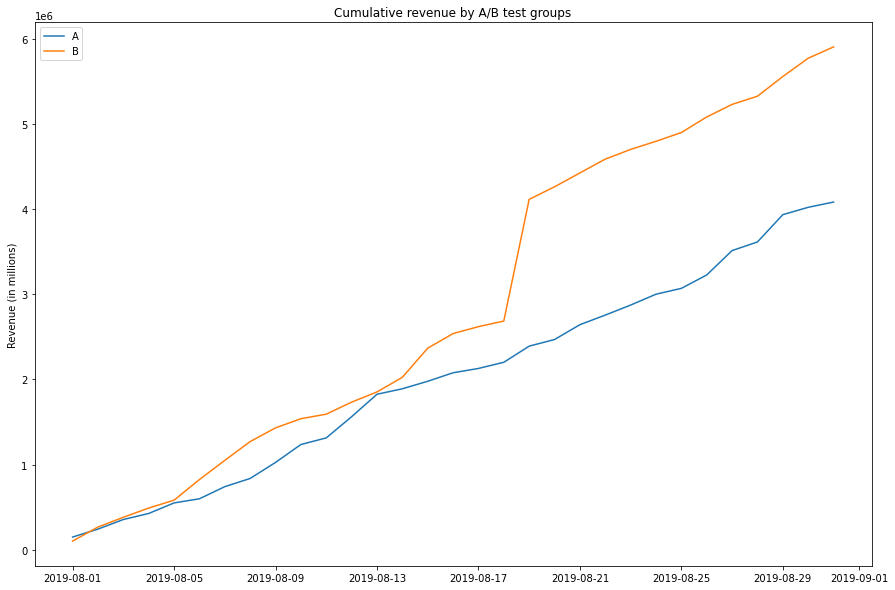

In [28]:
# Set the grid size for charts
plt.figure(figsize=(15, 10))

# Group A revenue chart
plt.plot(merged_data['date'], merged_data['revenue_cummulative_a'], label='A')

# Group B revenue chart
plt.plot(merged_data['date'], merged_data['revenue_cummulative_b'], label='B')

plt.legend()
plt.title('Cumulative revenue by A/B test groups')
plt.ylabel('Revenue (in millions)');

**Findings:**

Revenue increases throughout the test, which is good.
However, Group B's revenue curve rises sharply between August 17 and 21, which could signal either a surge in orders or very expensive orders in the sample (outliers). This can skew the results of the A/B test, so let's analyze for outliers next.

<a id="avg_check"></a>

#### 4.1.2 Average check

Let's build graphs of the average bill by groups - we will divide the cumulative revenue by the cumulative number of orders:

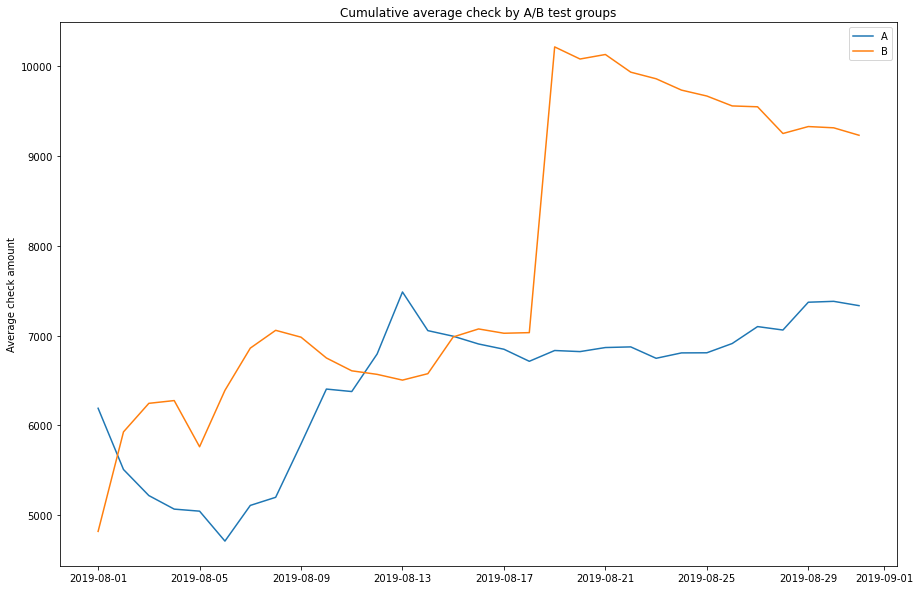

In [29]:
# Set the grid size for charts
plt.figure(figsize=(15, 10))

# Graph of the cumulative average check for group A
plt.plot(merged_data['date'], 
         merged_data['revenue_cummulative_a'] / merged_data['orders_cummulative_a'], 
         label='A')

# Graph of the cumulative average check for group B
plt.plot(merged_data['date'], 
         merged_data['revenue_cummulative_b'] / merged_data['orders_cummulative_b'], 
         label='B')

plt.legend()
plt.title('Cumulative average check by A/B test groups')
plt.ylabel('Average check amount');

**Findings:**

The average check fluctuates for both groups, but some outliers (possibly large orders) affected group B the most. After a sharp increase in the average check every August 17 and 21, the graph for group B begins to decline. Thus, sharp jumps on the chart do not allow visually judging the differences between the average checks of the groups.

<a id="avg_check_relat"></a>

#### 4.1.3 Relative change in the cumulative average check in groups

Let's build a graph of the relative difference for the average bill.

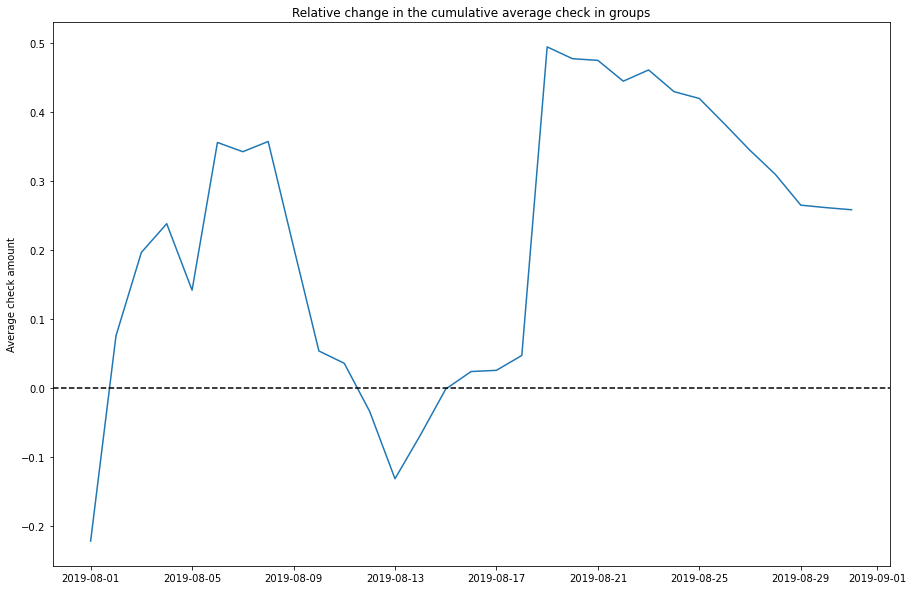

In [30]:
# Set the grid size for charts
plt.figure(figsize=(15, 10))

# The ratio of average checks
plt.plot(merged_data['date'], 
         (merged_data['revenue_cummulative_b'] / merged_data['orders_cummulative_b']) /
         (merged_data['revenue_cummulative_a'] / merged_data['orders_cummulative_a']) - 1)

# Adding the X Axis
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('Relative change in the cumulative average check in groups')
plt.ylabel('Average check amount');

**Findings:**

At several points, the graph of the difference between the segments fluctuates sharply. The data is heavily distorted by large orders and/or other outliers, so it is not yet possible to judge the test results. It will be necessary to "clear" the data.

<a id="avg_orders"></a>

#### 4.1.4 Average number of orders per user

To check what exactly influenced the outliers in the data, we plot the cumulative average number of orders per visitor by groups. To do this, we calculate the cumulative number of visitors for each date for each of the A/B test groups.

In [31]:
# Cumulative conversion for group A - the average number of orders per user
merged_data['conversion_a'] = (merged_data['orders_cummulative_a'] /
                               merged_data['visitors_cummulative_a'])

# Cumulative conversion for group B
merged_data['conversion_b'] = (merged_data['orders_cummulative_b'] /
                               merged_data['visitors_cummulative_b'])

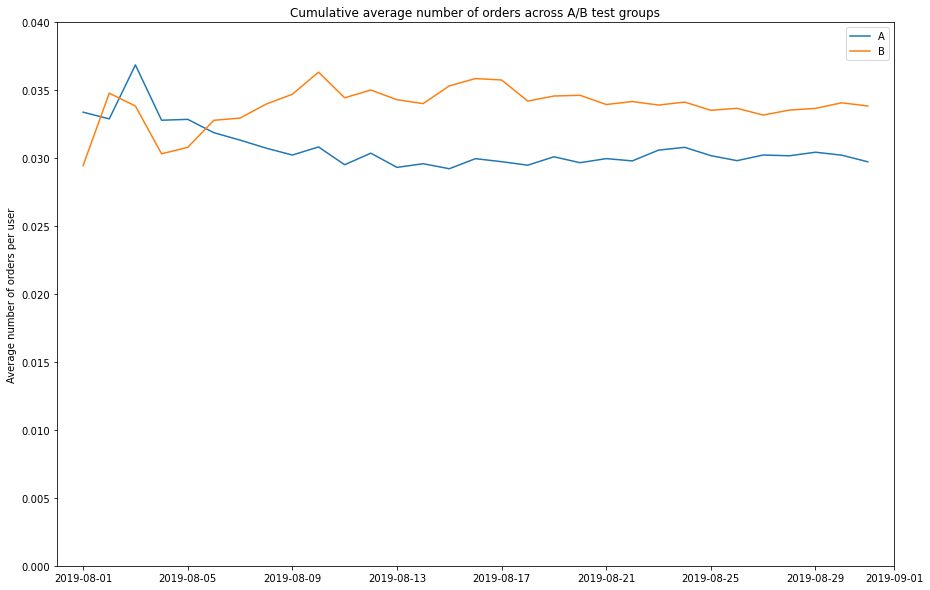

In [32]:
# Set the grid size for charts
plt.figure(figsize=(15, 10))

# Graph of the cumulative average check for group A
plt.plot(merged_data['date'], 
         merged_data['conversion_a'], 
         label='A')

# Graph of the cumulative average check for group B
plt.plot(merged_data['date'], 
         merged_data['conversion_b'], 
         label='B')

# Set the scale of the axes
plt.axis([dt.datetime.strptime('2019-07-31', '%Y-%m-%d').date(), 
          dt.datetime.strptime('2019-09-01', '%Y-%m-%d').date(), 
          0, 
          0.04]) 

plt.legend()
plt.title('Cumulative average number of orders across A/B test groups')
plt.ylabel('Average number of orders per user');

**Findings:**

The average number of orders per user becomes uniform towards the end of the test: fluctuate at the beginning of the month (due to the small amount of data at the beginning of the test, any outliers greatly affect the result, since the variance is larger), but by the second half of August, the indicators have settled down, and you can make a preliminary the conclusion is that for group B, the average number of orders per user is slightly higher.

<a id="avg_orders_relat"></a>

#### 4.1.5 Relative change in the cumulative average number of orders per visitor in groups

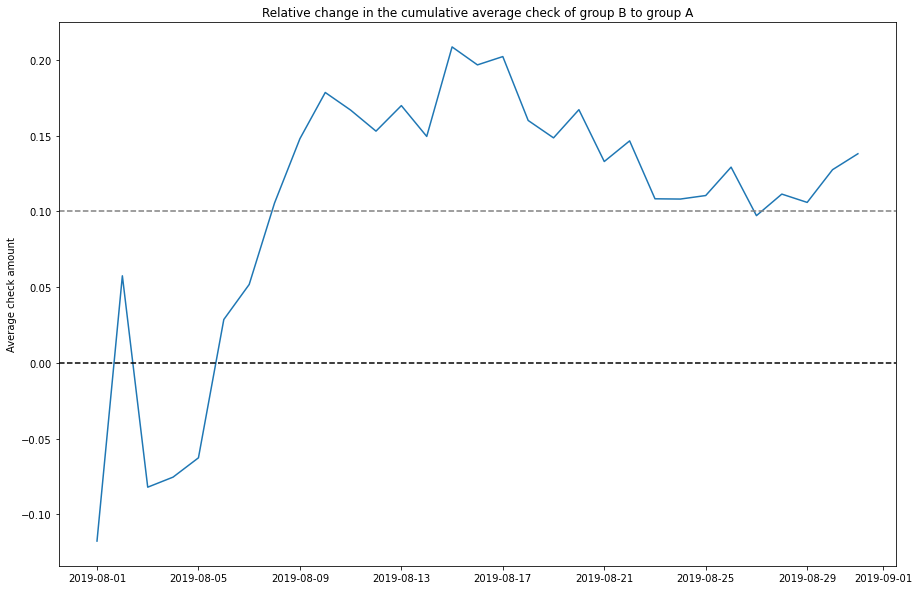

In [33]:
# Set the grid size for charts
plt.figure(figsize=(15, 10))

# Average checks relations
plt.plot(merged_data['date'], 
         (merged_data['orders_cummulative_b'] / merged_data['visitors_cummulative_b']) /
         (merged_data['orders_cummulative_a'] / merged_data['visitors_cummulative_a']) - 1)

# Adding the X Axis
plt.axhline(y=0, color='black', linestyle='--') 
plt.axhline(y=0.1, color='grey', linestyle='--')

plt.title('Relative change in the cumulative average check of group B to group A')
plt.ylabel('Average check amount');

**Findings:**

At the beginning of the test, group B was losing to group A, then pulled ahead. Closer to the end of the test, the cumulative average number of orders per visitor began to fluctuate around a value of + 10% relative to the indicator for group A.
In general, the conversion ratio has not yet been established, and now it is not worth drawing any conclusions from the test. Perhaps working with outliers will change the picture.

<a id="outliers"></a>

### 4.2 Outliers analysis 

<a id="orders"></a>

#### 4.2.1 Number of orders per user

In [34]:
# Count the number of orders per user
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

# Adding meaningful column names
orders_by_users.columns = ['visitor_id', 'orders']

# First 10 rows of the dataset
orders_by_users.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
866,4256040402,11
385,2458001652,11
361,2378935119,9
270,2038680547,8
557,3062433592,5
746,3803269165,5
726,3717692402,5
359,237748145,5
57,1230306981,5
258,199603092,5


It seems that most users do not make more than five orders. We will also build a dot plot of the number of orders by users to identify the boundary of emissions.

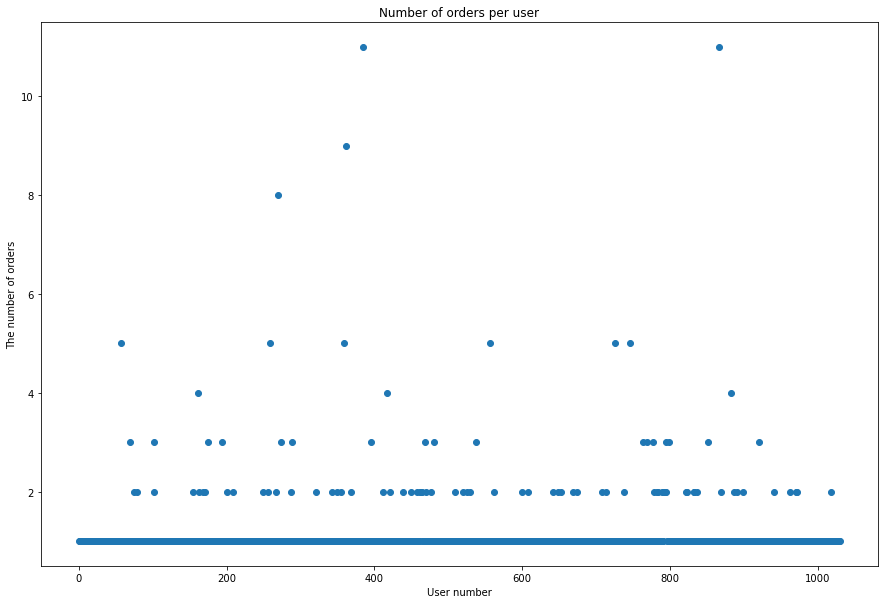

In [35]:
# Set the grid size for charts
plt.figure(figsize=(15, 10))

# Set the values of the X axis - from zero to the number of records in the orders table
x_values = pd.Series(range(0, len(orders_by_users)))

# Scatter plot of the number of orders by users
plt.scatter(x_values, orders_by_users['orders'])

plt.title('Number of orders per user')
plt.ylabel('The number of orders')
plt.xlabel('User number');

Most users did not make more than 6 orders. Let's check this statement by counting the 95th and 99th percentiles of the number of orders per user.

In [36]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[2. 4.]


No more than 5% of users have made more than 2 orders and no more than 1% - more than 4 orders.

Since most of the users on the chart seem to have made between 1-5 orders, let's define the abnormal number of orders as more than 5, which corresponds to the 95-99th percentile.

In [37]:
# What percentile is 5 orders per user?
percentile = stats.percentileofscore(orders_by_users['orders'], 5)

percentile

99.36954413191077

In [38]:
# Percentile value for outlier filtering
percentile_orders = np.percentile(orders_by_users['orders'], percentile)

percentile_orders

5.0

Thus, we will limit the outliers to about the 99.4th percentile.

<a id="orders_cost"></a>

#### 4.2.2 Orders cost

Let's build a dot plot of the cost of orders to identify the boundary of outliers.

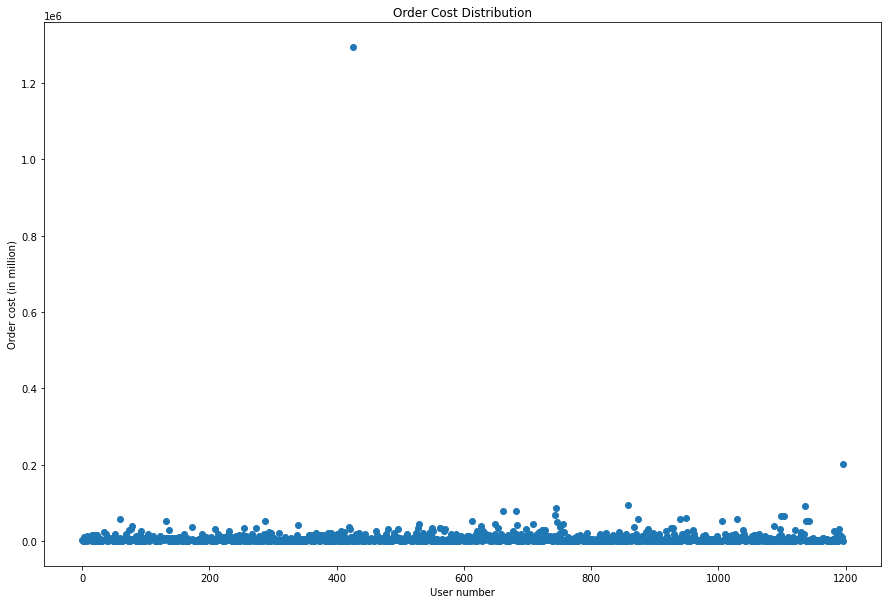

In [39]:
# Set the grid size for charts
plt.figure(figsize=(15, 10))

# Set the values of the X axis - from zero to the number of records in the orders table
x_values = pd.Series(range(0, len(orders['revenue'])))

# Scatter plot of the number of orders by users
plt.scatter(x_values, orders['revenue'])

plt.title('Order Cost Distribution')
plt.ylabel('Order cost (in million)')
plt.xlabel('User number');

The data clearly shows an outlier around 1,250,000 per order. The remaining orders brought revenue several times less.

This expensive order fell into one of the test groups and skewed the results. Purchases for such an amount are a rarity and an exception, which manifested itself not due to testing a hypothesis, but by chance.

Let's calculate the 95th and 99th percentiles of the order value and choose a border to detect anomalous orders.

In [40]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


No more than 5% of orders are more expensive than 28 thousand and no more than 1% are more expensive than 58 thousand rubles.

Since the majority of orders on the chart are within 20 thousand, we define the abnormal order amount as exceeding the 95th percentile.

In [41]:
# Store the selected percentile value for outlier filtering
percentile_revenue = np.percentile(orders['revenue'], 95)

percentile_revenue

28000.000000000004

<a id="hyp_test"></a>


### 4.3 Hypothesis testing

<a id="raw_avg_check_diff"></a>

#### 4.3.1 Differences in the average order check between groups ("raw" data)

Let's formulate and test hypotheses regarding differences in the average order receipt between groups according to "raw" data.

To do this, we will conduct a non-parametric (since there are many outliers in the data) Wilcoxon-Mann-Whitney test about the equality of the means of two samples.

The null hypothesis is always about the absence of differences, the first one is about their presence.

```
H_0: Average order receipts between A/B test groups are equal.
H_1: Average order receipts between A/B test groups differ.

alpha = 0.05
```

In [42]:
# Final sample for group A
sample_a = orders[orders['group']=='A']['revenue']

In [43]:
# Final sample for group B
sample_b = orders[orders['group']=='B']['revenue']

In [44]:
# The level of significance
alpha = 0.05

In [45]:
# Calling a Method to Test a Hypothesis
results = st.mannwhitneyu(sample_a, sample_b)

# p-value
print('p-value:', '{0:.5f}'.format(results[1]))

# Relative increase in the average number of orders of group B
print('Relative growth:', 
      '{0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))

# Conditional operator with the output of a string with the answer
if results.pvalue < alpha:
    print('We reject the null hypothesis: the difference is statistically significant')
else:
    print(
        'We cannot reject null hypothesis, the difference is NOT statistically significant'
    )

p-value: 0.72929
Relative growth: 0.259
We cannot reject null hypothesis, the difference is NOT statistically significant


**Findings:**

p-value = 0.729, which is more than the given significance level of 0.05.

Thus, the assumption that the average check per user did not change for group B could not be rejected. That is, the probability of an error in rejecting the null hypothesis (error of the first kind) is equal in our case to almost 73%. We have no reason to believe that the average checks differ for the two groups.

Thus, based on "raw" data, we can conclude that in the new interface of the online store, the average check of users from group B has not changed. However, the average check of group B is significantly higher than the average check of group A (almost by 26%), but these differences are not statistically significant.

<a id="raw_order_num_diff"></a>

#### 4.3.2 Differences in the number of orders per user between groups ("raw" data)

Let us formulate and test hypotheses regarding differences in the average number of orders per user between groups according to "raw" data.

To do this, we will conduct a non-parametric (since there are many outliers in the data) Wilcoxon-Mann-Whitney test about the equality of the means of two samples.

The null hypothesis is always about the absence of differences, the first one is about their presence.

```
H_0: Average orders per user are equal for both A/B test groups.
H_1: Average orders per user differ.

alpha = 0.05
```

To test the hypotheses, we will create two datasets `orders_by_users_a` and `orders_by_users_b`, in which we will collect all users who made at least one order, and also put zeros for users who did not order anything (their number is equal to the difference between the sum of visitors and the number of order records ).

In [46]:
# Number of orders for users in group A (only users with orders)
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

# Adding meaningful column names
orders_by_users_a.columns = ['visitor_id', 'orders']

# Users who have not made any orders
zero_orders_a = (
    pd
    .Series(0, 
            index=np.arange(merged_data['visitors_per_date_a'].sum() -
                            len(orders_by_users_a['orders'])), 
            name='orders')
)

# Final sample - add users who have not made a single order to the dataset
sample_a = pd.concat([orders_by_users_a['orders'], zero_orders_a], axis=0)

In [47]:
# Number of orders for users in group B (only users with orders)
orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

# Adding meaningful column names
orders_by_users_b.columns = ['visitor_id', 'orders']

# Users who have not made any orders
zero_orders_b = (
    pd
    .Series(0, 
            index=np.arange(merged_data['visitors_per_date_b'].sum() -
                            len(orders_by_users_b['orders'])), 
            name='orders')
)

# Final sample - add users who have not made a single order to the dataset
sample_b = pd.concat([orders_by_users_b['orders'], zero_orders_b], axis=0)

In [48]:
# The level of significance
alpha = 0.05  

In [49]:
# Calling a Method to Test a Hypothesis
results = st.mannwhitneyu(sample_a, sample_b)

# p-value
print('p-value:', '{0:.5f}'.format(results[1]))

# Relative increase in the average number of orders of group B
print('Relative growth:', 
      '{0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))

# Conditional operator with the output of a string with the answer
if results.pvalue < alpha:
    print('We reject the null hypothesis: the difference is statistically significant')
else:
    print(
        'We cannot reject null hypothesis, the difference is NOT statistically significant'
    )

p-value: 0.01679
Relative growth: 0.138
We reject the null hypothesis: the difference is statistically significant


**Findings:**

p-value = 0.017, which is less than the given significance level of 0.05.

Thus, the assumption that the number of orders per user did not change for group B was rejected. That is, the probability of an error in rejecting the null hypothesis (error of the first kind) is equal in our case to 1.7%. Since this is quite small, we have reason to believe that the number of orders per user varies.

Thus, on the "raw" data, we can conclude that in the new interface of the online store, users began to make 13.8% more orders.

<a id="cleaned_avg_check_diff"></a>

#### 4.3.3 Differences in the average order check between groups ("cleaned" data)

Let us formulate and test hypotheses regarding the differences in the average check between groups according to the "cleaned" data.

To do this, we will conduct the Wilcoxon-Mann-Whitney test to the obtained samples.


```
H_0: Average order receipts between A/B test groups are equal.
H_1: Average order receipts between A/B test groups differ.

alpha = 0.05
```

We recognized as anomalous users who made more than 5 orders and who made an order for more than 28 thousand. That is, we will remove about 1% of users with an abnormally large number of orders and from 1 to 5% of users with an abnormally high order receipt.

Let's calculate how many users will not be included in the final sample.

In [50]:
# Users with an abnormally large number of orders
users_with_many_orders = pd.concat(
    [orders_by_users_a[orders_by_users_a['orders'] > percentile_orders]['visitor_id'],
     orders_by_users_b[orders_by_users_b['orders'] > percentile_orders]['visitor_id']],
    axis=0)

# Users with abnormally expensive orders
users_with_expensive_orders = orders[orders['revenue'] > percentile_revenue]['visitor_id']

# "Abnormal" Users
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [51]:
# Number of "Abnormal" users
print(abnormal_users.shape[0]) 

# First 5 rows
abnormal_users.head(5)

58


1103    1164614297
137     1211585711
1136    1307669133
858     1316129916
421     1357170471
Name: visitor_id, dtype: object

There are 58 abnormal users in total.


Let's find out how their actions influenced the test results. Let's calculate the statistical significance of the differences in the average order receipt between the groups of the A/B test according to the "cleaned" data.

To do this, we will prepare samples of the number of orders per user by groups.

In [52]:
# Final sample for group A
sample_a = (
    orders[
        np.logical_and(orders['group'] == 'A',
                       np.logical_not(orders['visitor_id'].isin(abnormal_users)))
    ]['revenue']
)

In [53]:
# Final sample for group B
sample_b = (
    orders[
        np.logical_and(orders['group'] == 'B',
                       np.logical_not(orders['visitor_id'].isin(abnormal_users)))
    ]['revenue']
)

In [54]:
# The level of significance
alpha = 0.05  

In [55]:
# Calling a Method to Test a Hypothesis
results = st.mannwhitneyu(sample_a, sample_b)

# p-value
print('p-value:', '{0:.5f}'.format(results[1]))

# Relative increase in the average number of orders of group B
print('Relative growth:', 
      '{0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))

# Conditional operator with the output of a string with the answer
if results.pvalue < alpha:
    print('We reject the null hypothesis: the difference is statistically significant')
else:
    print(
        'We cannot reject null hypothesis, the difference is NOT statistically significant'
    )

p-value: 0.89336
Relative growth: -0.010
We cannot reject null hypothesis, the difference is NOT statistically significant


**Findings:**

p-value = 0.893, which is much higher than the given significance level of 0.05.

Thus, the assumption that the average check per user did not change for group B could not be rejected on the "cleaned" data. That is, the probability of error when rejecting the null hypothesis (error of the first kind) is 89%, that is, there is no reason to believe that the average check per user for group B is different from group A.

Thus, on the "cleaned" data, we can conclude that in the new interface of the online store, the average check of users from group B has not changed compared to group A, that is, the conclusion has not changed for "cleaned" data compared to "raw". At the same time, group B shows "negative growth" - that is, a worse result than group A for "clean" data, while on raw data due to emissions, group B showed an increase of more than 1/4 of the average bill.

<a id="cleaned_order_num_diff"></a>

#### 4.3.4 Differences in the number of orders per user between groups ("cleaned" data)

Let us formulate and test hypotheses regarding differences in the average number of orders per user between groups according to "cleaned" data.

To do this, we will conduct the Wilcoxon-Mann-Whitney test to the obtained samples.

The null hypothesis is always about the absence of differences, the first one is about their presence.

```
H_0: Average orders per user between A/B test groups are equal.
H_1: Average orders per user between A/B test groups differ.

alpha = 0.05
```

In [56]:
# Users who have not made a single order
zero_orders_a = (
    pd.Series(
    0,
    index=np.arange(merged_data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), 
    name='orders')
)

# Final sample for group A - added users who made 0 orders
sample_a = (
    pd
    .concat(
        [orders_by_users_a[np.logical_not(orders_by_users_a['visitor_id']
                                          .isin(abnormal_users))]['orders'],
         zero_orders_a],
    axis=0)
)

In [57]:
# Users who have not made a single order
zero_orders_b = (
    pd.Series(
    0,
    index=np.arange(merged_data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), 
    name='orders')
)

# Final sample for group B - added users who made 0 orders
sample_b = (
    pd
    .concat(
        [orders_by_users_b[np.logical_not(orders_by_users_b['visitor_id']
                                          .isin(abnormal_users))]['orders'],
         zero_orders_b],
    axis=0)
)

In [58]:
# The level of significance
alpha = 0.05 

In [59]:
# Calling a Method to Test a Hypothesis
results = st.mannwhitneyu(sample_a, sample_b)

# p-value
print('p-value:', '{0:.5f}'.format(results[1]))

# Relative increase in the average number of orders of group B
print('Relative growth:', 
      '{0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))

# Conditional operator with the output of a string with the answer
if results.pvalue < alpha:
    print('We reject the null hypothesis: the difference is statistically significant')
else:
    print(
        'We cannot reject null hypothesis, the difference is NOT statistically significant'
    )

p-value: 0.01859
Relative growth: 0.140
We reject the null hypothesis: the difference is statistically significant


**Findings:**

p-value = 0.019, which is less than the given significance level of 0.05.

Thus, the assumption that the number of orders per user did not change for group B was rejected. That is, the probability of an error in rejecting the null hypothesis (error of the first kind) is equal in our case to 1.9%. Since this is small enough, we have reason to believe that the number of orders per user for group B is different from group A.

Thus, on the "cleaned" data, we can conclude that in the new interface of the online store, users began to make 14% more orders. That is, the result was "confirmed" on "pure" data too.

It is worth noting that at a lower significance level alpha = 0.01, the null hypothesis would not be rejected.

<a id="conclusion"></a>

## 5. General conclusion

**Project purpose:** prioritize hypotheses, run an A/B test, and make a decision based on the results.

*Input data:*
- a set of hypotheses, compiled jointly with the marketing department, and their evaluation using the ICE and RICE frameworks;
- data on visits, orders and revenue of the online store divided into test groups from August 1 to August 31, 2019;
- A/B test duration - 31 days; about 19 thousand observations were collected for each group.

*Applying results:*
- testing the most priority hypotheses in the first place;
- making a decision to continue the A / B test or stop it and fix the results.

*Research hypotheses:*

- Hypothesis 1. The average check for group B will be significantly higher than for group A.
- Hypothesis 2. The number of orders per user for group B will be significantly higher than for group A.

**Results**

1) The most promising hypotheses for testing are (in descending order of priority):

- №7: `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок` (затронет 100% пользователей);
- №2: `Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа`;
- №0: `Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей`.

These hypotheses have the highest priority according to the RICE methodology. The rest of the hypotheses scored significantly lower, with 1-4 points on reach, which corresponds to low coverage, and also scored low on impact and confidence, and/or scored high on efforts. That is, with a small impact and certainty of this impact on the user, a disproportionate amount of resources will be expended.
Therefore, we can assume that the study of other hypotheses will not be appropriate.

2) **Hypothesis 1 - not accepted**

- Failed to reject the assumption about the equality of average checks for groups A and B (p-value = 0.89).
- There is no reason to believe that the average check per user for group B is different from group A.
- At the same time, group B shows a worse result than group A on data cleared of outliers (users with an abnormally large number of orders and an abnormally high check per order were removed), while on raw data (with outliers), group B showed an increase of more than 1/4 of the average check.


3) **Hypothesis 2 - accepted**

- It was possible to reject the assumption of the average number of orders per user for groups A and B (p-value = 0.02).
- There is reason to believe that the number of orders per user for group B is different from group A.
- On the "cleaned" data in the new interface of the online store, users began to make 14% more orders.
- With a more rigorous test, the null hypothesis would not be rejected - more data would be needed for validation.


**Recommendations**

- Stop the test.
- Record the victory of group B: users of the new interface began to make more orders on average.
- Fix the absence of differences in the average bill of user orders for the two groups.